In [1]:

# basic imports
from __future__ import print_function
import numpy as np
from numpy.linalg import eig, inv
import time

# plotting elements
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
cmap = cm.RdBu_r



# exptool imports
from exptool.io import psp_io
from exptool.utils import kde_3d
from exptool.observables import transform
from exptool.analysis import pattern
from exptool.analysis import trapping
from exptool.utils import *
from exptool.observables import visualize

# astropy imports
import astropy.coordinates as coord
import astropy.units as u

import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline
import scipy

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2


import reflexmotion as rm

from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

from astropy.io import fits


In [2]:

#http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_sgr-coordinate-frame.html

from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
import astropy.coordinates as coord
import astropy.units as u

class Sagittarius(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the orbit
    of the Sagittarius dwarf galaxy, as described in
        http://adsabs.harvard.edu/abs/2003ApJ...599.1082M
    and further explained in
        http://www.stsci.edu/~dlaw/Sgr/.

    Parameters
    ----------
    representation : `BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    Lambda : `Angle`, optional, must be keyword
        The longitude-like angle corresponding to Sagittarius' orbit.
    Beta : `Angle`, optional, must be keyword
        The latitude-like angle corresponding to Sagittarius' orbit.
    distance : `Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The radial velocity of this object.

    """

    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'Lambda'),
            coord.RepresentationMapping('lat', 'Beta'),
            coord.RepresentationMapping('distance', 'distance')]
    }
    
    

SGR_PHI = (180 + 3.75) * u.degree # Euler angles (from Law & Majewski 2010)
SGR_THETA = (90 - 13.46) * u.degree
SGR_PSI = (180 + 14.111534) * u.degree


# Generate the rotation matrix using the x-convention (see Goldstein)
D = rotation_matrix(SGR_PHI, "z")
C = rotation_matrix(SGR_THETA, "x")
B = rotation_matrix(SGR_PSI, "z")
A = np.diag([1.,1.,-1.])
SGR_MATRIX = matrix_product(A, B, C, D)

@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, Sagittarius)
def galactic_to_sgr():
    """ Compute the transformation matrix from Galactic spherical to
        heliocentric Sgr coordinates.
    """
    return SGR_MATRIX

@frame_transform_graph.transform(coord.StaticMatrixTransform, Sagittarius, coord.Galactic)
def sgr_to_galactic():
    """ Compute the transformation matrix from heliocentric Sgr coordinates to
        spherical Galactic.
    """
    return matrix_transpose(SGR_MATRIX)




In [3]:
# see https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu3ast/sec_cu3ast_intro/ssec_cu3ast_intro_tansforms.html


def return_gaia_Agprime():
    """return the matrix in eq 3.61, key to transform from ICRS to galactic coordinates"""
    return np.array([[-0.0548755604162154,-0.8734370902348850,-0.4838350155487132],
                     [+0.4941094278755837,-0.4448296299600112,+0.7469822444972189],
                     [-0.8676661490190047,-0.1980763734312015,+0.4559837761750669]])

def return_ricrs(a,d):
    """ eq. 3.57"""
    return np.array([np.cos(a)*np.cos(d),np.sin(a)*np.cos(d),np.sin(d)])

def return_picrs(a,d):
    """ eq. 3.64, unit vector of increasing alpha"""
    if hasattr(a,'size'):
        return np.array([-np.sin(a),np.cos(a),np.zeros(a.size)])
    else:
        return np.array([-np.sin(a),np.cos(a),0.])

def return_qicrs(a,d):
    """ eq. 3.64, unit vector of increasing delta"""
    return np.array([-np.cos(a)*np.sin(d),-np.sin(a)*np.sin(d),np.cos(d)])

def return_muicrs(a,d,mua,mud):
    """ eq. 3.66, the proper motion vector"""
    p = return_picrs(a,d)
    q = return_qicrs(a,d)
    return p*mua + q*mud



def return_rgal(l,b):
    """ eq. 3.58"""
    return np.array([np.cos(l)*np.cos(b),np.sin(l)*np.cos(b),np.sin(b)])

def return_pgal(l,b):
    """ eq. 3.66, unit vector of increasing alpha"""
    if hasattr(l,'size'):
        return np.array([-np.sin(l),np.cos(l),0.*np.cos(l)])
    else:
        return np.array([-np.sin(l),np.cos(l),0.*np.cos(l)])

def return_qgal(l,b):
    """ eq. 3.66, unit vector of increasing delta"""
    return np.array([-np.cos(l)*np.sin(b),-np.sin(l)*np.sin(b),np.cos(b)])

def return_mugal(l,b,mul,mub):
    """ eq. 3.66, the proper motion vector"""
    p = return_pgal(l,b)
    q = return_qgal(l,b)
    return p*mul + q*mub


def rotate_velocities(a,d,mua,mud):
    """eq 3.68, """
    mu = return_muicrs(a,d,mua,mud)
    mugal = np.dot(return_gaia_Agprime(),mu) # eq. 3.68
    
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))
    
    p = return_pgal(ell,b)
    q = return_qgal(ell,b)
    
    mul = np.sum(p*mugal,axis=0)
    mub = np.sum(q*mugal,axis=0)
    #print(mul,mub)
    return mul,mub



def rotate_errors(a,d,pmra_e,pmdec_e,pmcorr):
    ricrs = return_ricrs(a,d)
    picrs = return_picrs(a,d)
    qicrs = return_qicrs(a,d)

    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell = np.arctan2(rgal[1],rgal[0])
    b = np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    pgal = return_pgal(ell,b)
    qgal = return_qgal(ell,b)

    pqgal = np.stack((pgal, qgal), axis=-1)
    pqicrs = np.stack((picrs, qicrs), axis=-1)

    cov = np.array([[pmra_e*pmra_e,pmra_e*pmdec_e*pmcorr],[pmra_e*pmdec_e*pmcorr,pmdec_e*pmdec_e]])
    #print(cov)

    G = np.einsum('ab,ac->bc', pqgal,
                      np.einsum('ji,ik->jk', return_gaia_Agprime(), pqicrs))

    cov_to = np.einsum('ba,ac->bc', G,
                           np.einsum('ij,ki->jk', cov, G))
    
    return cov_to

#print(G)

def rotate_positions(a,d,dist):
    """eq 3.68, but built for speed"""
    # solve for positions
    if a.size>1:
        ricrs = return_ricrs(a,d)
        rgal = np.dot(return_gaia_Agprime(),ricrs)
        cpos = dist*rgal        
    else:
        ricrs = return_ricrs(a,d)
        rgal = np.dot(return_gaia_Agprime(),ricrs)
        cpos = np.dot(dist,rgal)        
    return cpos


a = 45.*np.pi/180.
d = 60.*np.pi/180.
mua = 1.
mud = -1.

#print(return_muicrs(a,d,mua,mud))

print(rotate_velocities(a,d,mua,mud))

#cov_to = rotate_errors(a,d,1,2.,0.)
#print(cov_to)


#print(ricrs,rgal,ell,b)

(1.3543164832139731, -0.4072184466535577)


In [73]:



a,d = Gmatch['ra'][pmatch]*np.pi/180.,Gmatch['dec'][pmatch]*np.pi/180.
mua,mud = Gmatch['pmra'][pmatch],Gmatch['pmdec'][pmatch]

def rotate_errors(a,d,pmra_e,pmdec_e,pmcorr):
    ricrs = return_ricrs(a,d)
    picrs = return_picrs(a,d)
    qicrs = return_qicrs(a,d)

    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell = np.arctan2(rgal[1],rgal[0])
    b = np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    pgal = return_pgal(ell,b)
    qgal = return_qgal(ell,b)

    pqgal = np.stack((pgal, qgal), axis=-1)
    pqicrs = np.stack((picrs, qicrs), axis=-1)
    
    cov = np.array([[pmra_e*pmra_e,pmra_e*pmdec_e*pmcorr],[pmra_e*pmdec_e*pmcorr,pmdec_e*pmdec_e]])
    #print(cov)
    
    
    

    

    if hasattr(a,'size'):
        G = np.einsum('anb,acn->nbc', pqgal,
                      np.einsum('ji,ink->jkn', return_gaia_Agprime(), pqicrs))

        cov_to = np.einsum('nba,nac->nbc', G,
                           np.einsum('ijn,nki->njk', cov, G))
        
    else:
        G = np.einsum('ab,ac->bc', pqgal,
                      np.einsum('ji,ik->jk', return_gaia_Agprime(), pqicrs))

        cov_to = np.einsum('ba,ac->bc', G,
                           np.einsum('ij,ki->jk', cov, G))
    
    return cov_to

    
a,d,mua,mud = 4.412988523884174, -0.7016329830211496, -9.064863611635216, -5.376376155701305
cov_to = rotate_errors(a,d,mua,mud,0.*mua)
print(cov_to)


a,d = Gmatch['ra'][pmatch]*np.pi/180.,Gmatch['dec'][pmatch]*np.pi/180.
mua,mud = Gmatch['pmra'][pmatch],Gmatch['pmdec'][pmatch]

cov_to = rotate_errors(a[0:12],d[0:12],mua[0:12],mud[0:12],0.*mua[0:12])
print(cov_to[10])


[[ 50.47103223 -26.1466139 ]
 [-26.1466139   60.60614063]]
[[ 50.47103223 -26.1466139 ]
 [-26.1466139   60.60614063]]


In [71]:
print(a[10],d[10],mua[10],mud[10])

4.412988523884174 -0.7016329830211496 -9.064863611635216 -5.376376155701305


In [25]:
atmp = 4.429556
print(atmp.size)

AttributeError: 'float' object has no attribute 'size'

NameError: name 'cov_to' is not defined

In [ ]:
best_latlon  = cbest.transform_to('galactic')

In [12]:
xp,yp,zp = rotate_positions(Gmatch['ra'][pmatch]*np.pi/180.,Gmatch['dec'][pmatch]*np.pi/180.,dist)



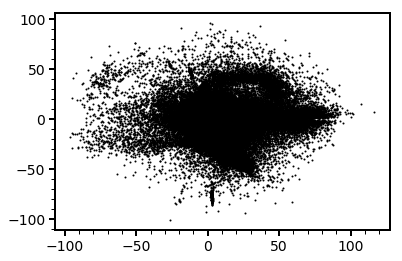

In [13]:
plt.scatter(xp,zp,color='black',s=1.)

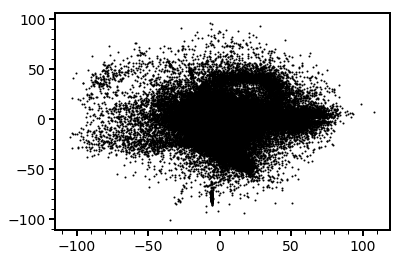

In [88]:
cbest = coord.SkyCoord(ra              = Gmatch['ra'][pmatch]    * u.deg,\
                       dec             = Gmatch['dec'][pmatch]   * u.deg,\
                       distance        = dist  * u.kpc)


best_defined = cbest.transform_to(gc_frame)
best_sgr     = cbest.transform_to(Sagittarius)
best_latlon  = cbest.transform_to('galactic')

plt.scatter(best_defined.x,best_defined.z,color='black',s=1.)

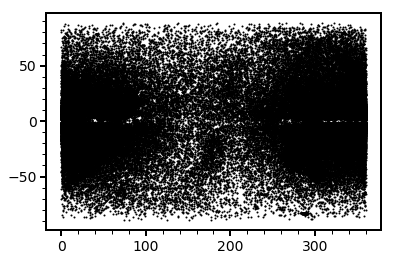

In [89]:
plt.scatter(best_latlon.l,best_latlon.b,color='black',s=1.)

In [150]:
indx = 11

a = Gmatch['ra'][pmatch][indx]*np.pi/180.
d = Gmatch['dec'][pmatch][indx]*np.pi/180.

#%timeit ricrs = return_ricrs(a,d)


In [151]:
ricrs = return_ricrs(a,d)
A = return_gaia_Agprime()
#%timeit rgal = np.dot(A,ricrs)

In [152]:
rgal = np.dot(return_gaia_Agprime(),ricrs)
print(rgal)
#%timeit np.dot(dist[indx],rgal)

[ 0.96237108 -0.2680665   0.04452247]


In [198]:
indx = 0
rotate_positions(Gmatch['ra'][pmatch][indx]*np.pi/180.,\
                                                        Gmatch['dec'][pmatch][indx]*np.pi/180.,\
                                                        dist[indx])

array([ 38.55669468, -10.56406227,   1.34040449])

In [ ]:
for indx in range(0,pmatch.size):
    if (indx % 1000 == 0): print(indx)
    xpos[indx],ypos[indx],zpos[indx] = rotate_positions(Gmatch['ra'][pmatch][indx]*np.pi/180.,\
                                                        Gmatch['dec'][pmatch][indx]*np.pi/180.,\
                                                        dist[indx])



In [4]:
!ls data/*Jorge*

data/Sgr_LAMOST_DR5_KG_obsid_forJorge.fits
data/lamost_kg_dr5_halo_forJorge.fits
data/lamost_kg_dr5_smoothhalo_forJorge.fits


In [54]:

C17 = np.genfromtxt('/Users/mpetersen/Notebooks/Dynamics/Shells/cohen17.txt',\
                        dtype={'names': ("sgr","per","hjd","ampr",\
                                         "rmag","nr","ng","qual",\
                                         "RA","Dec","dist","nsp",\
                                         "rvgsr","ervgsr","date"),\
                             'formats': ('S20','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                         'f8','f8','f8')},\
                 skip_header=66)





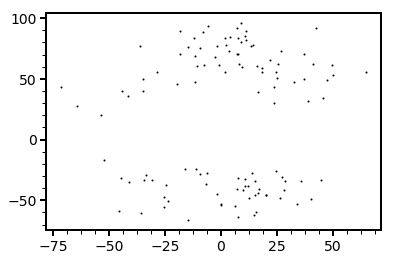

In [6]:
xpos,ypos,zpos = np.zeros(C17['RA'].size),np.zeros(C17['RA'].size),np.zeros(C17['RA'].size)

for indx in range(0,C17['RA'].size):
    xpos[indx],ypos[indx],zpos[indx] = rotate_positions(C17['RA'][indx]*np.pi/180.,C17['Dec'][indx]*np.pi/180.,C17['dist'][indx])

plt.scatter(xpos,zpos,color='black',s=1.)

In [301]:
Gmatch["source_id"]

array([b'90198608955264', b'205780473330048', b'219219426355200', ...,
       b'6912668773929549056', b'6912692177207121024',
       b'6912944824363453568'], dtype='|S20')

In [33]:
Gmatch = np.genfromtxt('/Users/mpetersen/Downloads/cohen17_corr-result.csv',\
                        dtype={'names': ("xsource_id","gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","pmra_pmdec_corr","dist"),\
                             'formats': ('S20','S20','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8','f8')},\
                 skip_header=1,delimiter=',')

In [6]:

# now with RUWE!
Gmatch = np.genfromtxt('/Users/mpetersen/Downloads/cohen_corr_ruwe-result.csv',\
                        dtype={'names': ("dec","parallax","dist","parallax_error",\
                                         "phot_bp_mean_flux_error","bp_rp","pmra","a_g_val","ra_error",\
                                         "pmra_error","pmdec_error","radial_velocity_error","pmra_pmdec_corr",\
                                         "teff_val","phot_g_mean_flux","phot_variable_flag","ra",\
                                         "phot_bp_mean_flux","phot_g_mean_flux_error","radial_velocity",\
                                         "dec_error","name","pmdec","phot_g_mean_mag","ruwe","source_id"),\
                             'formats': ('f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8',\
                                         'f8','S20','f8','f8','f8','S20')},\
                 skip_header=1,delimiter=',')

In [7]:
print(Gmatch['pmra'])

[ 1.45704100e-01  9.98221472e-01  1.38968430e+00  1.61170607e+00
  1.37519893e-01  8.63302488e-01  2.02880589e+00 -3.26448513e-01
  1.20673143e+00 -5.40916984e-01  5.97188059e-02 -7.59628445e-01
  1.12499522e-01 -2.09915889e+00  2.44248573e+00 -3.70089614e-01
             nan -9.98909758e-01  2.35620894e-01 -3.32040356e+00
  7.76109823e-01 -1.02002135e+00 -7.07290084e-01  1.37939743e-01
 -3.98076169e-01  1.28738262e+00 -1.68618497e+00  5.69475392e-01
  2.31309070e-01 -3.57790302e-01 -3.57499424e-01 -1.97831562e+00
 -2.03608660e+00 -1.08220667e+00 -1.03088036e+00  3.86908124e-01
 -2.18327745e+00 -1.28738679e-01  5.48337525e-01  3.72803787e-01
  5.77204210e-01 -1.65210026e-01 -2.48595031e-01 -1.17491914e+00
  4.00037438e-02 -1.86754095e+00 -2.32854532e-02  2.93757157e+00
 -1.91772263e+00 -1.85942300e+00 -1.04476640e+00 -1.03777563e+00
  7.14448340e-01 -4.57584685e-01 -1.34338381e+00 -3.62150948e-03
 -3.85725039e-01 -2.67209485e-01  2.80816590e-02  1.24527553e+00
 -2.14104431e-01 -1.01594

In [46]:
print(Gmatch['ruwe'])

[1.0595022  1.0558776  1.0309095  0.94892    1.0455922  0.91754687
 1.034767   0.90555215 0.9552674  1.0879066  1.066541   1.0535487
 1.0600315  0.98340374 1.0113455  1.1398855         nan 0.9542892
 1.0073326  0.99274445 0.9779225  1.0434934  0.9825461  0.9488022
 1.0436572  1.0194228  0.983159   1.0240927  0.95504886 0.95698786
 0.9352879  1.0328686  1.0140067  1.0069655  0.97808886 0.99326
 1.0117781  1.0164856  0.93398935 0.9754205  1.0094391  0.9959188
 1.0042089  0.9833959  0.9895391  1.0593865  0.94511944 1.0766734
 0.9551718  0.94484526 1.061316   1.0529302  1.1190357  1.0467572
 1.045499   0.9279445  0.9647465  1.0197444  0.87253517 1.1346891
 0.9203129  0.9469259         nan 1.2104374  0.9886527  0.90944016
 1.0068961  0.99320287 0.95123607 0.9975518  0.99278754 1.0074794
 1.0018101  0.91265106        nan 1.0334768  1.1660376  0.96323776
 0.86215675 1.085313   0.97515935        nan 0.9764313  1.0193242
        nan 1.0569     1.1703418         nan 0.97319376 0.9740569
 0.94781

In [41]:
Gmatch['xsource_id'].astype('S20')
xsources = [int(d.decode()) for d in Gmatch['xsource_id']]

ValueError: invalid literal for int() with base 10: '0.3241104334145973'

In [10]:
pmatch = []
for i in obsid:
    #print(i,xsources[0:10])
    w = np.where(xsources==i)[0]
    #print(w,w.size)
    if w.size>1:
        print(i,w,Gmatch['dist'][w],w[np.nanargmin(Gmatch['dist'][w])])
        pmatch.append(w[np.nanargmin(Gmatch['dist'][w])])
    else:
        pmatch.append(w[0])
    #print(w.size)

NameError: name 'obsid' is not defined

54


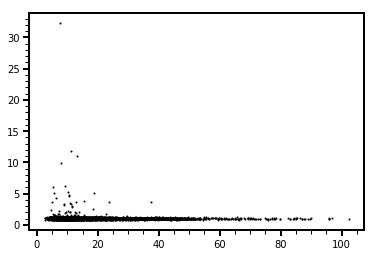

In [127]:
plt.scatter(dist,Gmatch['ruwe'][pmatch],color='black',s=1.)
bigruwe = np.where(Gmatch['ruwe'][pmatch]>=1.4)[0]
print(bigruwe.size)
goodruwe = np.where(Gmatch['ruwe'][pmatch]<1.4)[0]

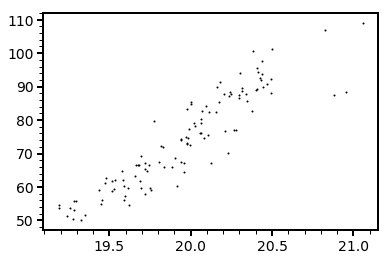

In [13]:
plt.scatter(Gmatch['phot_g_mean_mag'],C17['dist'],color='black',s=1.)

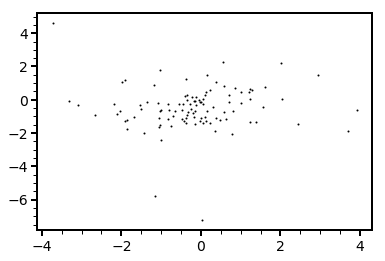

In [14]:
bigd = np.where(C17['dist']>40)

k = 4.74057
vra = Gmatch['pmra']

plt.scatter(Gmatch['pmra'][bigd],Gmatch['pmdec'][bigd],color='black',s=1.)

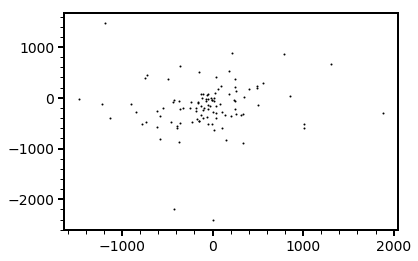

In [16]:
k = 4.74057
vra = Gmatch['pmra']*C17['dist']*k
vdec = Gmatch['pmdec']*C17['dist']*k

plt.scatter(vra,vdec,color='black',s=1.)


In [87]:
# set the coordinates for transformation

# use the schonrich 2010 peculiar motions
usun = 11.1
vsun = 12.24
wsun = 7.25

# use the circular velocity from ...
vcirc = 235.

# the value of mcmillan 2017
vcirc = 220.
#vcirc = 244.
#vcirc = 232.

# use the gravity 2018 result for the galactic center distance
rsun = 8.3 # in kpc

# use the sun's height above the midplane from Bovy...
zsun = 20 # in pc

v_sun = coord.CartesianDifferential([usun, vsun+vcirc, wsun]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=rsun*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=zsun*u.pc)




In [52]:

ra = C17['RA']
dec = C17['Dec']
dist = C17['dist']
edist = 0.1*C17['dist']
rv = C17['rvgsr']
erv = C17['ervgsr']


def find_errors(indx,nsamples=10000,verbose=False,sgr=False):
    rat = ra[indx]
    dect = dec[indx]
    dt = dist[indx]
    derrt = edist[indx]
    pmrat = Gmatch['pmra'][indx]
    pmraerrt = Gmatch['pmra_error'][indx]
    pmdect = Gmatch['pmdec'][indx]
    pmdecerrt = Gmatch['pmdec_error'][indx]
    vradt = rv[indx]
    vraderrt = erv[indx]
    
    print(rat,dect,dt)

    cplus = coord.SkyCoord(ra              = np.tile(rat,nsamples)                                 * u.deg,\
                           dec             = np.tile(dect,nsamples)                                 * u.deg,\
                           distance        = np.nanmax([np.zeros(nsamples)+.1,(dt     + np.random.normal(size=nsamples)*derrt)],axis=0)     * u.kpc,\
                           pm_ra_cosdec    = (pmrat  + np.random.normal(size=nsamples)*pmraerrt)  * u.mas/u.yr,\
                           pm_dec          = (pmdect + np.random.normal(size=nsamples)*pmdecerrt) * u.mas/u.yr,\
                           radial_velocity = (vradt  + np.random.normal(size=nsamples)*vraderrt)  * u.km/u.s)

    cbest = coord.SkyCoord(ra              = rat    * u.deg,\
                           dec             = dect   * u.deg,\
                           distance        = dt     * u.kpc,\
                           pm_ra_cosdec    = pmrat  * u.mas/u.yr,\
                           pm_dec          = pmdect * u.mas/u.yr,\
                           radial_velocity = vradt  * u.km/u.s)

    if verbose:
        print(pmrat,pmdect,vradt)

    gal_latlon  = cplus.transform_to('galactic')
    gal_defined = cplus.transform_to(gc_frame)
        
    best_latlon  = cbest.transform_to('galactic')
    best_defined = cbest.transform_to(gc_frame)
    
    if sgr:
        best_sgr = cbest.transform_to(Sagittarius)
        return gal_latlon,gal_defined,best_latlon,best_defined,best_sgr
    
    else:
        return gal_latlon,gal_defined,best_latlon,best_defined


indx = 0
gal_latlon,gal_defined,best_latlon,best_defined = find_errors(indx,nsamples=1000,verbose=False)

gal_latlon,gal_defined,best_latlon,best_defined,best_sgr = find_errors(indx,nsamples=1000,verbose=True,sgr=True)


print(best_defined)

print(best_latlon)
print(best_sgr)


NameError: name 'C17' is not defined

In [27]:
Gmatch['pmra'][1]

-0.13741135573919835

In [24]:
indx = 2
rotate_velocities(ra[indx]*np.pi/180.,dec[indx]*np.pi/180.,Gmatch['pmra'][indx],Gmatch['pmdec'][indx])




(0.8034036103591531, -0.6868023136201)

In [29]:
cbest = coord.SkyCoord(ra              = ra    * u.deg,\
                       dec             = dec   * u.deg,\
                       distance        = dist  * u.kpc,\
                       pm_ra_cosdec    = Gmatch['pmra']  * u.mas/u.yr,\
                       pm_dec          = Gmatch['pmdec'] * u.mas/u.yr,\
                       radial_velocity = rv  * u.km/u.s)

best_defined = cbest.transform_to(gc_frame)
best_sgr     = cbest.transform_to(Sagittarius)
best_latlon  = cbest.transform_to('galactic')

plt.scatter(best_defined.x,best_defined.z,color='black',s=1.)

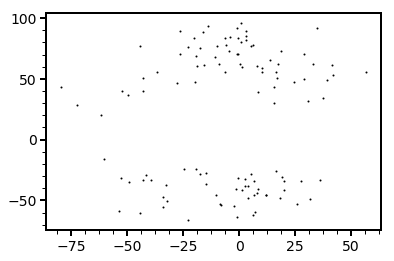

In [34]:
# back out the rotated correlation coefficients

pmatch = np.arange(0,len(Gmatch['pmra_error']),1)
pm_l_err = np.zeros(len(pmatch))
pm_b_err = np.zeros(len(pmatch))
corrcoef = np.zeros(len(pmatch))
pm_l     = np.zeros(len(pmatch))
pm_b     = np.zeros(len(pmatch))

for i in range(0,len(pmatch)):
    #print(i)
    e1 = Gmatch['pmra_error'][i]
    e2 = Gmatch['pmdec_error'][pmatch][i]
    e3 = Gmatch['pmra_pmdec_corr'][pmatch][i]
    cov_to = rotate_errors(Gmatch['ra'][pmatch][i]*np.pi/180.,Gmatch['dec'][pmatch][i]*np.pi/180.,\
                       e1,e2,e3)
    
    corrcoef[i] = cov_to[0][1]/(np.sqrt(cov_to[0][0])*np.sqrt(cov_to[1][1]))
    pm_l_err[i] = np.sqrt(cov_to[0][0])
    pm_b_err[i] = np.sqrt(cov_to[1][1])
    
    lbvel = rotate_velocities(Gmatch['ra'][pmatch][i]*np.pi/180.,Gmatch['dec'][pmatch][i]*np.pi/180.,\
                              Gmatch['pmra'][pmatch][i],Gmatch['pmdec'][pmatch][i])
    
    pm_l[i] = lbvel[0]
    pm_b[i] = lbvel[1]






In [35]:
corrcoef.size

112

In [36]:
pm_l[0],pm_b[0]

(nan, nan)

In [37]:
np.array(best_latlon.pm_b[100]),pm_b[100]

(array(-0.18262975), -0.18263084995377418)

In [50]:

f = open('/Users/mpetersen/Dropbox/mike/data/CohenRRL.txt','w')

print("x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s];      l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr];       edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];      sgrweak [bool]; sgrstrong [bool]; FeH [dex]; Sgr Lambda [deg]; Sgr Beta [deg]; Belokurov Flag [bool]; corrcoef [-1:1]",file=f)

rej = 0
for i in range(0,len(pmatch)):
    if (Gmatch['ruwe'][pmatch][i] < 1.4) & (np.isfinite(np.array(best_defined.v_y)[i])):
        print(np.array(best_defined.x)[i],np.array(best_defined.y)[i],np.array(best_defined.z)[i],\
              np.array(best_defined.v_x)[i],np.array(best_defined.v_y)[i],np.array(best_defined.v_z)[i],\
              np.array(best_latlon.l)[i],np.array(best_latlon.b)[i],dist[i],\
              rv[i],pm_l[i],pm_b[i],\
              edist[i],erv[i],pm_l_err[i],pm_b_err[i],\
              0,0,0,\
              np.array(best_sgr.Lambda)[i],np.array(best_sgr.Beta)[i],0,\
              corrcoef[i],file=f)
    else:
        rej +=1
        print('REJECTED!')
    
          
f.close()
print(rej)


REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
15


In [4]:




# now with RUWE!
Gmatch = np.genfromtxt('/Users/mpetersen/Downloads/variables_with_ruwe-result.csv',\
                        dtype={'names': ("pmdec_error","dec","radial_velocity_error","pmra_pmdec_corr",\
                                    "parallax","best_class_name","teff_val","parallax_error","phot_g_mean_flux",\
                                    "phot_bp_mean_flux_error","ra","phot_bp_mean_flux","phot_g_mean_flux_error",\
                                    "best_class_score","radial_velocity","bp_rp","dec_error",\
                                    "pmra","pmdec","a_g_val",\
                                    "ra_error","pmra_error","phot_g_mean_mag","ruwe","source_id"),\
                             'formats': ('f8','f8','f8','f8',\
                                         'f8','S20','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8',\
                                         'f8','f8','f8','f8','S20')},\
                 skip_header=1,delimiter=',')

In [5]:
Gmatch['radial_velocity'].size

363969

In [6]:
np.unique(Gmatch['best_class_name'])

array([b'ACEP', b'ARRD', b'CEP', b'DSCT_SXPHE', b'MIRA_SR', b'RRAB',
       b'RRC', b'RRD', b'T2CEP'], dtype='|S20')

In [7]:
pmatch = np.where(np.isfinite(Gmatch['pmra']) & \
                  np.isfinite(Gmatch['pmdec']) & \
                  (Gmatch['ruwe'] < 1.4) &\
                  ( (Gmatch['best_class_name']==b'RRAB') | \
                    (Gmatch['best_class_name']==b'RRC') | \
                    (Gmatch['best_class_name']==b'RRD') | \
                    (Gmatch['best_class_name']==b'ARRD') ))[0]

print(pmatch.size)

157347


In [8]:
grvs = Gmatch['radial_velocity'][pmatch][np.isfinite(Gmatch['radial_velocity'][pmatch])]
print(grvs.size)

368


(0.0, 5.0)

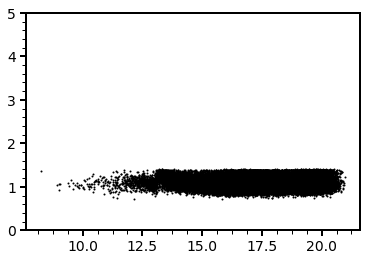

In [9]:
plt.scatter(Gmatch['phot_g_mean_mag'][pmatch],Gmatch['ruwe'][pmatch],color='black',s=1.)

plt.ylim(0.,5.)


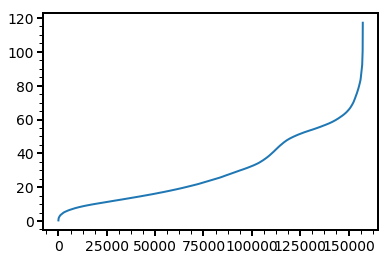

In [10]:

zeropoint = 0.64 # this is M_G from Iorio 2018

dist = 10.**(((Gmatch['phot_g_mean_mag'][pmatch]-zeropoint)/5) - 2.)

plt.plot(dist[dist.argsort()])




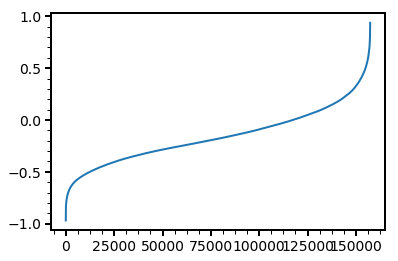

In [83]:
# do all velocity transforms

e1 = Gmatch['pmra_error'][pmatch]
e2 = Gmatch['pmdec_error'][pmatch]
e3 = Gmatch['pmra_pmdec_corr'][pmatch]
cov_to = rotate_errors(Gmatch['ra'][pmatch]*np.pi/180.,Gmatch['dec'][pmatch]*np.pi/180.,\
                       e1,e2,e3)

corrcoef = np.array([cov_to[i][0][1]/(np.sqrt(cov_to[i][0][0])*np.sqrt(cov_to[i][1][1])) for i in range(0,len(pmatch))])
pm_l_err = np.array([np.sqrt(cov_to[i][0][0]) for i in range(0,len(pmatch))])
pm_b_err = np.array([np.sqrt(cov_to[i][1][1]) for i in range(0,len(pmatch))])

pm_l,pm_b = rotate_velocities(Gmatch['ra'][pmatch]*np.pi/180.,Gmatch['dec'][pmatch]*np.pi/180.,\
                              Gmatch['pmra'][pmatch],Gmatch['pmdec'][pmatch])

plt.plot(corrcoef[corrcoef.argsort()])

In [ ]:

f = open('/Users/mpetersen/Dropbox/mike/data/RRL_GaiaI.txt','w')

print("x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s];      l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr];       edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];      sgrweak [bool]; sgrstrong [bool]; FeH [dex]; Sgr Lambda [deg]; Sgr Beta [deg]; Belokurov Flag [bool]; corrcoef [-1:1]",file=f)

rej = 0
for i in range(0,len(pmatch)):
    #print(np.abs((np.array(best_latlon.b)[i])))
    if (Gmatch['ruwe'][pmatch][i] < 1.4) & (np.abs(np.array(best_latlon.b)[i])>10.):
        print(np.array(best_defined.x)[i],np.array(best_defined.y)[i],np.array(best_defined.z)[i],\
              #np.array(best_defined.v_x)[i],np.array(best_defined.v_y)[i],np.array(best_defined.v_z)[i],\
              0,0,0,\
              np.array(best_latlon.l)[i],np.array(best_latlon.b)[i],dist[i],\
              0.,pm_l[i],pm_b[i],\
              0.1*dist[i],0.,pm_l_err[i],pm_b_err[i],\
              0,0,0,\
              np.array(best_sgr.Lambda)[i],np.array(best_sgr.Beta)[i],0,\
              corrcoef[i],file=f)
    else:
        rej +=1
        #print('REJECTED!')
    
          
f.close()
print(rej)

